## Raspagem de dados de escanteios da pagina de UM time no site TOTALCORNER

In [84]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cloudscraper

scraper = cloudscraper.create_scraper()

#Raspagem de dados to site TOTALCORNER de UM TIME
def get_corner_stats(team_id:str,is_home:bool='all'):
    
    n_pages = 3
    league_names = []
    first_half_corners_for = []
    second_half_corners_for = []
    match_corners_for = []
    first_half_corners_against = []
    second_half_corners_against = []
    match_corners_against = []
    total_match_corners = []
    total_first_half_corners = []
    total_second_half_corners =[]
    home_or_away = []
    corners_balance =[]
    against = []
    team_name = ''

    for page in range(1,n_pages + 1):
        time.sleep(1)

        html = scraper.get(f'https://www.totalcorner.com/team/view/{team_id}/page:{page}').content

        soup = BeautifulSoup(html, 'html.parser')
        if not soup.find("meta", {"name":"description"}):
            print('CAPTCHA')
            break
        if team_name == '':
            team_name = soup.find("meta", {"name":"description"})["content"]
            team_name = team_name.split(",")[0].replace('Team: ','')
        



        table_rows = soup.findAll("tr")
        for rows in table_rows:
            #Ignorando jogos que ainda não aconteceram
            if rows.find("span", class_="span_half_corner hide"):
                continue
            match = rows.find("td", class_="match_home")
            #Pegando nome do time que joga em casa
            if match != None:
                home_team = match.find('a').text
            #Ignorando possiveis linhas que não são referente a partidas
            else:
                continue
            match = rows.find("td", class_="match_away")
            #Pegando nome do time que joga fora de casa
            if match != None:
                away_team = match.find('a').text
            #Pegando dados sobre escanteios
            league_name = rows.find("td", class_="td_league").find('a',href=True)
            league_name = league_name.text
            half_corners = rows.find("span", class_="span_half_corner").text
            match_corners = rows.find("span", class_="span_match_corner").text
            home_half_corners = half_corners.replace('(','').replace(')','').split('-')[0]
            away_half_corners = half_corners.replace('(','').replace(')','').split('-')[1]
            home_match_corners = match_corners.split(' ')[0]
            away_match_corners = match_corners.split(' ')[-1]
            home_second_half_corners = int(home_match_corners) - int(home_half_corners)
            away_second_half_corners = int(away_match_corners) - int(away_half_corners)
            #Organizando dados para o dataframe
            league_names.append(league_name)
            if home_team == team_name:
                against.append(away_team)            
                balance = int(home_match_corners) - int(away_match_corners)
                first_half_corners_for.append(int(home_half_corners))
                second_half_corners_for.append(int(home_second_half_corners))
                match_corners_for.append(int(home_match_corners))
                first_half_corners_against.append(int(away_half_corners))
                second_half_corners_against.append(int(away_second_half_corners))
                match_corners_against.append(int(away_match_corners))
                total_match_corners.append(int(home_match_corners) + int(away_match_corners))
                total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
                total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
                home_or_away.append('Home')
                corners_balance.append(balance)

            else:
                against.append(home_team)  
                balance = int(away_match_corners) - int(home_match_corners)
                first_half_corners_for.append(int(away_half_corners))
                second_half_corners_for.append(int(away_second_half_corners))
                match_corners_for.append(int(away_match_corners))
                first_half_corners_against.append(int(home_half_corners))
                second_half_corners_against.append(int(home_second_half_corners))
                match_corners_against.append(int(home_match_corners))
                total_match_corners.append(int(home_match_corners) + int(away_match_corners))
                total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
                total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
                home_or_away.append('Away')
                corners_balance.append(balance)
    #Criando DataFrame
    df = pd.DataFrame(list(zip(
            league_names,
            first_half_corners_for,
            second_half_corners_for,
            match_corners_for,
            first_half_corners_against,
            second_half_corners_against,
            match_corners_against,
            total_match_corners,
            total_first_half_corners,
            total_second_half_corners,
            home_or_away,
            corners_balance,
            against
        )),
        columns=[
            'league_name',
            'first_half_corners_for',
            'second_half_corners_for',
            'match_corners_for',
            'first_half_corners_against',
            'second_half_corners_against',
            'match_corners_against',
            'total_match_corners',
            'total_first_half_corners',
            'total_second_half_corners',
            'home_or_away',
            'corners_balance',
            'against'

        ])
    if is_home == 'all':
        return (team_name, df)
    if is_home:
        return (team_name, df[(df.home_or_away == "Home")])
    else:
        return (team_name, df[(df.home_or_away == "Away")])


## Raspagem de dados de 'N' jogos de um campeonato no site TOTALCORNER

In [85]:
import datetime
def get_league_stats(league_href, minimum_games):
  date = []
  home_team = []
  home_goals = []
  away_goals = []
  away_team = []
  ft_home_corners = []
  ft_away_corners = []
  ht_home_corners = []
  ht_away_corners = []
  home_atacks = []
  away_attacks = []
  home_shots = []
  away_shots = []


  while len(date) < minimum_games:
    page = 1
    scraper = cloudscraper.create_scraper()
    html = scraper.get(f'https://www.totalcorner.com{league_href}/page:{page}').content
    time.sleep(1)
    soup = BeautifulSoup(html, 'html5lib')
    if not soup.find("meta", {"name":"description"}):
      print('CAPTCHA')
    table = soup.find_all('tr')
    table.pop(0)
    year = datetime.date.today().year
    for rows in table:
      match_status = rows.find('td',class_='match_status')
      if (not match_status):
        if rows.text:
          year = rows.text.split(' ')[1].strip()
        continue
      if ('Full' not in match_status.text):
        continue
      row_data = rows.find_all('td')
      date.append(row_data[0].text.strip().split(' ')[0]+'/'+year+' '+row_data[0].text.strip().split(' ')[1])
      home_team.append(row_data[2].text.strip().replace('\n',''))
      home_goals.append(int(row_data[3].text.strip().replace('\n','').split('-')[0].strip()))
      away_goals.append(int(row_data[3].text.strip().replace('\n','').split('-')[1].strip()))
      away_team.append(row_data[4].text.strip().replace('\n',''))
      ft_home_corners.append(int(row_data[6].text.strip().replace('\n','').split('-')[0].strip()))
      ft_away_corners.append(int(row_data[6].text.strip().replace('\n','').split('-')[1].strip()))
      ht_home_corners.append(int(row_data[7].text.strip().replace('\n','').split('-')[0].strip()))
      ht_away_corners.append(int(row_data[7].text.strip().replace('\n','').split('-')[1].strip()))
      home_atacks.append(int(row_data[12].text.strip().replace('\n','').split('-')[0].strip()))
      away_attacks.append(int(row_data[12].text.strip().replace('\n','').split('-')[1].strip()))
      home_shots.append(int(row_data[13].text.strip().replace('\n','').split('-')[0].strip()))
      away_shots.append(int(row_data[13].text.strip().replace('\n','').split('-')[1].strip()))
    page += 1
  df = pd.DataFrame(list(zip(
    date,
    home_team ,
    home_goals ,
    away_goals ,
    away_team ,
    ft_home_corners ,
    ft_away_corners ,
    ht_home_corners ,
    ht_away_corners ,
    home_atacks ,
    away_attacks ,
    home_shots ,
    away_shots ,    
  )),
  columns=[
    'date',
    'home_team' ,
    'home_goals' ,
    'away_goals' ,
    'away_team' ,
    'ft_home_corners' ,
    'ft_away_corners' ,
    'ht_home_corners' ,
    'ht_away_corners' ,
    'home_atacks' ,
    'away_attacks' ,
    'home_shots' ,
    'away_shots' ,
  ])
  return(df)


### Criando relátorio com fairlines de escanteios para as principais partidas de hoje

Função que retorna os valores esperados de escanteio a favor do time da casa e visitante no primeiro tempo e na partida completa

In [86]:
def get_expected_corners(league_df, df_home, df_away):
    #Calculando força de ataque e defesa relativo a liga para cada time
    #Calculando as medias da liga
    ft_home_league_corners_avg = round(league_df['ft_home_corners'].mean(),2)
    ft_away_league_corners_avg = round(league_df['ft_away_corners'].mean(),2)
    ht_home_league_corners_avg = round(league_df['ht_home_corners'].mean(),2)
    ht_away_league_corners_avg = round(league_df['ht_away_corners'].mean(),2)
    #Força de ataque do time da casa
    ft_home_team_corners_avg = round(df_home['match_corners_for'].mean(),2)
    ht_home_team_corners_avg = round(df_home['first_half_corners_for'].mean(),2)
    ft_home_atk_force = ft_home_team_corners_avg/ft_home_league_corners_avg
    ht_home_atk_force = ht_home_team_corners_avg/ht_home_league_corners_avg
    #Força defesa time da casa
    ft_home_team_corners_against_avg = round(df_home['match_corners_against'].mean(),2)
    ht_home_team_corners_against_avg = round(df_home['first_half_corners_against'].mean(),2)
    ft_home_def_force = ft_home_team_corners_against_avg/ft_away_league_corners_avg
    ht_home_def_force = ht_home_team_corners_against_avg/ht_away_league_corners_avg
    #Força ataque time visitante
    ft_away_tem_corners_avg = round(df_away['match_corners_for'].mean(),2)
    ht_away_team_corners_avg = round(df_away['first_half_corners_for'].mean(),2)
    ft_away_atk_force = ft_away_tem_corners_avg/ft_away_league_corners_avg
    ht_away_atk_force = ht_away_team_corners_avg/ht_away_league_corners_avg
    #Força defesa time visitante
    ft_away_team_corners_against_avg = round(df_away['match_corners_against'].mean(),2)
    ht_away_team_corners_against_avg = round(df_away['first_half_corners_against'].mean(),2)
    ft_away_def_force = ft_away_team_corners_against_avg/ft_home_league_corners_avg
    ht_away_def_force = ht_away_team_corners_against_avg/ht_home_league_corners_avg

    #Escanteios esperados time casa
    #Home team attack * away team defence * média numero de gols dos mandantes
    x_corners_home_ft = ft_home_atk_force * ft_away_def_force * ft_home_league_corners_avg 
    x_corners_home_ht = ht_home_atk_force * ht_away_def_force * ht_home_league_corners_avg

    #Escanteios esperados time visitante
    x_corners_away_ft = ft_away_atk_force * ft_home_def_force * ft_away_league_corners_avg
    x_corners_away_ht = ht_away_atk_force * ht_home_def_force * ht_away_league_corners_avg
    return {
        'home_ft':x_corners_home_ft,
        'home_ht':x_corners_home_ht,
        'away_ft':x_corners_away_ft,
        'away_ht':x_corners_away_ht
        }

Função que calcula as probabilidades utilizando uma distribuição de poisson

In [93]:
import datetime
from scipy.stats import poisson


def get_fairlines(expected_corners,corners_range,ht_corners_range):
    #Probabilidades a partir de distribuição de poisson
    ft_home_corners_probabilities = poisson.pmf(k=corners_range, mu=expected_corners['home_ft'])
    ht_home_corners_probabilities = poisson.pmf(k=ht_corners_range, mu=expected_corners['home_ht'])

    ft_away_corners_probabilities = poisson.pmf(k=corners_range, mu=expected_corners['away_ft'])
    ht_away_corners_probabilities = poisson.pmf(k=ht_corners_range, mu=expected_corners['away_ht'])

    ft_probability_matrix = pd.DataFrame(1,
                                    index=[list(corners_range),ft_away_corners_probabilities],
                                    columns=[list(corners_range),list(ft_home_corners_probabilities)]
                                    )
    ft_probability_matrix = ft_probability_matrix.multiply(ft_away_corners_probabilities, axis='index') * ft_home_corners_probabilities
    ht_probability_matrix = pd.DataFrame(1,
                                    index=[list(ht_corners_range),ht_away_corners_probabilities],
                                    columns=[list(ht_corners_range),list(ht_home_corners_probabilities)]
                                    )
    ht_probability_matrix = ht_probability_matrix.multiply(ht_away_corners_probabilities, axis='index') * ht_home_corners_probabilities
    
    fairlines = {}
    ft_over_range = range(6,13)
    ht_over_range = range(2,8)
    ht_under_range = range(7,2,-1)
    ft_under_range = range(12,5,-1)
    for n_corner in ft_over_range:
        fairlines[f'FT_over_{n_corner}.5'] = 0
        for i in range(max(list(ft_over_range))+1):
            fairlines[f'FT_over_{n_corner}.5'] += ft_probability_matrix.loc[i, n_corner + 1 - i :].sum(axis=1).tolist()[0]
        fairlines[f'FT_over_{n_corner}.5'] = 1/fairlines[f'FT_over_{n_corner}.5']

    for n_corner in ft_under_range:
        fairlines[f'FT_under_{n_corner}.5'] = 0
        for i in range(max(list(ft_under_range))+1):
            fairlines[f'FT_under_{n_corner}.5'] += ft_probability_matrix.loc[i,  :n_corner - i].sum(axis=1).tolist()[0]
        fairlines[f'FT_under_{n_corner}.5'] = 1/fairlines[f'FT_under_{n_corner}.5']

    for n_corner in ht_over_range:
        fairlines[f'1H_over_{n_corner}.5'] = 0
        for i in range(max(list(ht_over_range))+1):
            fairlines[f'1H_over_{n_corner}.5'] += ht_probability_matrix.loc[i, n_corner + 1 - i :].sum(axis=1).tolist()[0]
        fairlines[f'1H_over_{n_corner}.5'] = 1/fairlines[f'1H_over_{n_corner}.5']

    for n_corner in ht_under_range:
        fairlines[f'1H_under_{n_corner}.5'] = 0
        for i in range(max(list(ht_under_range))+1):
            fairlines[f'1H_under_{n_corner}.5'] += ht_probability_matrix.loc[i,  :n_corner - i].sum(axis=1).tolist()[0]
        fairlines[f'1H_under_{n_corner}.5'] = 1/fairlines[f'1H_under_{n_corner}.5']  

    return fairlines

Raspagem dos dados para identificar as partidas do dia e gerar as fairlines

In [94]:
def generate_report():
    scraper = cloudscraper.create_scraper()
    desired_leagues = ["France Ligue 1",'Portugal Primeira Liga','Netherlands Eredivisie','	Spain Primera Liga','Spain Segunda','Italy Serie B',
                       'England Championship','England Premier League','Germany Bundesliga I','Italy Serie A','Colombia Primera A','Uruguay Apertura',
                        'Chile Primera Division','Argentina Liga Profesional','USA MLS','Paraguay Division Profesional',
                       'Venezuela Primera Division','Mexico Liga MX','Japan J-League','Germany Bundesliga II','UEFA Champions League',
                       'Copa do Brasil','Copa Libertadores','Copa Sudamericana','UEFA Europa League','Brazil Serie A',
                       'Argentina Liga Profesional','Germany DFB Pokal']
    result = []
    html = scraper.get('https://www.totalcorner.com/match/schedule/20230511').content
    soup = BeautifulSoup(html, 'html.parser')
    date = soup.select('h3 > small')[0].text
    leagues_data = []
    table_rows = soup.find_all("tr")
    #Lendo as linhas da tabela
    for rows in table_rows:
        game = {}
        minutes = rows.find('span', class_="match_status_minutes")
        #ignorando linhas que não tem a coluna de tempo da partida
        if not minutes:
            continue
        #ignorando partidas que já começaram
        if minutes.text == "":
            links = rows.find_all('a', href=True)
            league = links[0].text
            league_href = links[0]['href']
            #Filtrando ligas
            if league not in desired_leagues:
                continue
            #Pegando ID dos times
            home_team_id = links[1]['href'].split('/')[-1]
            away_team_id = links[2]['href'].split('/')[-1]
            #Pegando os dados de escanteios dos times.
            home_team_name, df_home = get_corner_stats(home_team_id,True)
            time.sleep(1)
            away_team_name, df_away = get_corner_stats(away_team_id,False)
            #Dados escanteios da liga
            print(league)
            league_df = [element['df'] for element in leagues_data if element['name'] == league]
            if len(league_df) == 0:
                print('league not saved, scraping...')
                league_df = get_league_stats(league_href,200)
                leagues_data.append({'name':league,'df':league_df})
            else:
                print('league already found')
                league_df = league_df[0]
            #Encerra o loop caso o site peça CAPTCHA
            if not (home_team_name and away_team_name):
                break
            else:
                print(f'{home_team_name} X {away_team_name}')
                expected_corners = get_expected_corners(league_df,df_home,df_away)
                corners_range = range(0,13)
                ht_corners_range = range(0,8)
                game['Name'] = f'{home_team_name} X {away_team_name}'
                game.update(get_fairlines(expected_corners,corners_range,ht_corners_range))
                result.append(game)

    result_df = pd.DataFrame.from_records(result)
    try:
        with pd.ExcelWriter(f'fairlines{date}.xlsx',mode='a',engine="openpyxl",if_sheet_exists='replace') as writer:
            result_df.to_excel(writer, index=False,sheet_name='Fairlines')
    except:
        with pd.ExcelWriter(f'fairlines{date}.xlsx',mode='w',engine="openpyxl") as writer:
            result_df.to_excel(writer, index=False,sheet_name='Fairlines')
                    
generate_report()

Brazil Serie A
league not saved, scraping...
Palmeiras X Gremio
Brazil Serie A
league already found
Cruzeiro X Fluminense
Chile Primera Division
league not saved, scraping...
Universidad Catolica X Huachipato
Mexico Liga MX
league not saved, scraping...
Santos Laguna X Monterrey
Colombia Primera A
league not saved, scraping...
Millonarios X Alianza Petrolera
Mexico Liga MX
league already found
Atletico San Luis X Club America
UEFA Europa League
league not saved, scraping...
Juventus X Sevilla
UEFA Europa League
league already found
Roma X Bayer Leverkusen
Brazil Serie A
league already found
Botafogo RJ X Corinthians
Brazil Serie A
league already found
Coritiba X Vasco Da Gama RJ


### Pegando odds da Betano

In [95]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By


def get_odds(search_term):
    try:
        print('Getting odds for', search_term)
        url = "https://br.betano.com/" 
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--window-size=1920x1080')
        driver = webdriver.Chrome(options=options)
        driver.get(url) 
        
        # Garantindo que a pagina foi carregada
        time.sleep(2)
        #Fechando popup inicial
        close_modal = driver.find_element(By.CLASS_NAME,'sb-modal__close__btn')
        close_modal.click()
        #clicando no icone de busca
        search = driver.find_element(By.CLASS_NAME,'sb-header__header__actions__search-icon')
        search.click()
        time.sleep(1)
        #Digitando confronto no input de busca
        driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term)
        time.sleep(3)
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.CONTROL + "a")
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(Keys.DELETE)
            driver.find_element(By.CLASS_NAME,'uk-input').send_keys(search_term.split('X')[0])
            time.sleep(3)
        #Caso não seja encontrado retorna um objeto com o nome do confronto
        if len(driver.find_elements(By.CLASS_NAME,'search-modal__empty-state')) != 0:
            print('Jogo Não encontrado')
            return {'Name':search_term}
        #Caso encontrado clica no primeiro resultado
        else:
            if len(driver.find_elements(By.CLASS_NAME,'search-result')) == 0:
                time.sleep(4)
            driver.find_element(By.CLASS_NAME,'search-result').click()
            time.sleep(5)
            #Procura categoria escanteio e clica nela
            categories = driver.find_elements(By.CLASS_NAME,'GTM-tab-name')
            for category in categories:
                if 'escanteios' in category.get_attribute("innerHTML").lower():
                    category.click()
                    time.sleep(2)
            #passa o html estatico para o beautiful soup
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            #Pega todos os mercados de escanteios
            corner_markets = soup.find_all('div',class_='markets__market__header__title')
            market_titles = ['Name']
            market_odds = [search_term]
            #Filtra apenas os mercados de interesse (FT Mais/Menos e HT Mais/Menos)
            #Armazena as odds e o nome do mercado em uma lista cada.
            for market in corner_markets:
                if 'Escanteios' in market.text.split()[0] and 'Mais/Menos' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','FT_over_').replace('Menos de','FT_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
                if 'Mais/Menos' in market.text.split()[0] and '1' in market.text.split()[1]:
                    parent_tag = market.parent.parent
                    titles = parent_tag.find_all('span',class_='selections__selection__title')
                    odds = parent_tag.find_all('span',class_='selections__selection__odd')
                    market_titles = market_titles + [title.text.replace('Mais de','1H_over_').replace('Menos de','1H_under_') for title in titles]
                    market_odds = market_odds + [odd.text.split()[0] for odd in odds]
            print('Odds Found !')        
            return dict(zip(market_titles,market_odds))
    except Exception as e:
        print('Error getting odds',str(e))
        return {'Name':search_term}
        

        


### Preenchendo planilha com ODDS betano

In [96]:
#Lê a planilha com as fairlines criadas
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today() + datetime.timedelta(days=1)}.xlsx')
odds_result = []
#Para cada jogo busca as odds na betano
for game in list(df_fairlines.Name):
    odds_result.append(get_odds(game))
#Cria um dataframe com as odds
odds_df = pd.DataFrame.from_records(odds_result)
display(odds_df.head(2))



Getting odds for Palmeiras X Gremio
Odds Found !
Getting odds for Cruzeiro X Fluminense
Odds Found !
Getting odds for Universidad Catolica X Huachipato
Odds Found !
Getting odds for Santos Laguna X Monterrey
Odds Found !
Getting odds for Millonarios X Alianza Petrolera
Odds Found !
Getting odds for Atletico San Luis X Club America
Odds Found !
Getting odds for Juventus X Sevilla
Odds Found !
Getting odds for Roma X Bayer Leverkusen
Odds Found !
Getting odds for Botafogo RJ X Corinthians
Odds Found !
Getting odds for Coritiba X Vasco Da Gama RJ
Odds Found !


,Name,FT_over_10.5,FT_under_10.5,1H_over_5.5,1H_under_5.5,FT_over_8.5,FT_under_8.5,FT_over_9.5,FT_under_9.5,FT_over_11.5,...,FT_over_15.5,FT_under_15.5,FT_over_16.5,FT_under_16.5,1H_over_1.5,1H_under_1.5,1H_over_8.5,1H_under_8.5,1H_over_9.5,1H_under_9.5
0,Palmeiras X Gremio,1.80,1.93,2.20,1.62,1.28,3.45,1.50,2.50,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cruzeiro X Fluminense,1.83,1.90,2.25,1.60,1.30,3.35,1.52,2.45,2.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Limpando e organizando os dataframes de ODDS e Fairlines para compará-los e encontrar oportunidades

In [97]:
df_fairlines = pd.read_excel(f'fairlines{datetime.date.today()  + datetime.timedelta(days=1)}.xlsx')
odds_df = pd.DataFrame.from_records(odds_result)
#Removendo colunas de odds que não tenham fairlines calculadas
for column in odds_df.columns:
    if column not in df_fairlines.columns:
        odds_df.drop(column,inplace=True, axis='columns')
#Reordenando as colunas
cols = list(odds_df.columns)
cols.pop(0)
sorted_cols = sorted(cols)
sorted_cols.insert(0,'Name')
odds_df = odds_df[sorted_cols]
df_fairlines = df_fairlines[sorted_cols]
#Removendo linhas que não foram encontradas odds na betano
df_fairlines = df_fairlines[df_fairlines.Name.isin(odds_df.Name)]
df_fairlines.reset_index(inplace=True,drop=True)
#Criando novo dataframe com a diferença entre fairline e odds
diff = pd.DataFrame()
df_fairlines.iloc[:,1:] = df_fairlines.iloc[:,1:].astype(float)
odds_df.iloc[:,1:] = odds_df.iloc[:,1:].astype(float)
diff['Name']= df_fairlines.Name
diff = pd.concat([diff, df_fairlines.iloc[:,1:] - odds_df.iloc[:,1:]],axis=1)
display(diff.head(2))



,Name,1H_over_2.5,1H_over_3.5,1H_over_4.5,1H_over_5.5,1H_over_6.5,1H_over_7.5,1H_under_3.5,1H_under_4.5,1H_under_5.5,...,FT_over_7.5,FT_over_8.5,FT_over_9.5,FT_under_10.5,FT_under_11.5,FT_under_12.5,FT_under_6.5,FT_under_7.5,FT_under_8.5,FT_under_9.5
0,Palmeiras X Gremio,NaN,0.164925,0.326997,0.71063,1.761386,5.286805,0.131519,-0.044078,-0.029414,...,NaN,0.19701,0.297077,-0.087525,-0.053831,-0.044277,NaN,NaN,-0.090797,-0.109222
1,Cruzeiro X Fluminense,NaN,0.275691,0.583548,1.29234,3.253702,9.598697,-0.473571,-0.315095,-0.164198,...,NaN,0.367475,0.605947,-0.322949,-0.22273,-0.143255,NaN,NaN,-0.723448,-0.489437


In [100]:
def get_odds(row):
    return odds_df.loc[odds_df["Name"] == row['Jogo']][row['Market']].values[0]
#Criando dataFrame onde fairline - odd(betano) < -0.14,
#  ou seja betano está pagando mais do que consideramos justo
oportunities = diff[diff.loc[:,'1H_over_2.5':] < -0.14]
#Removendo valores ausentes
oportunities.dropna(axis=0,how='all',inplace=True)
oportunities.dropna(axis=1,how='all',inplace=True)
#Pegando novamente o nome dos confrontos
oportunities = oportunities.merge(odds_df['Name'],left_index=True,right_index=True,how='inner')
oportunities.set_index("Name",inplace=True)
#Transformando as oportunidades em uma lista de entradas
oportunities = oportunities.stack().reset_index().set_axis(['Jogo', 'Market', 'Margem'], axis=1)
#Buscando as odds das oportunidades
oportunities['Odd'] = oportunities.apply(get_odds, axis=1 )
oportunities['Probabilidade'] = oportunities.apply(lambda x: 1/(x['Margem']+x['Odd']), axis=1 )
oportunities['Criada_em'] = datetime.date.today()
oportunities['Resultado'] = np.nan
display(oportunities)





,Jogo,Market,Margem,Odd,Probabilidade,Criada_em,Resultado
0,Cruzeiro X Fluminense,1H_under_3.5,-0.473571,3.45,0.335973,2023-05-10,NaN
1,Cruzeiro X Fluminense,1H_under_4.5,-0.315095,2.22,0.524961,2023-05-10,NaN
2,Cruzeiro X Fluminense,1H_under_5.5,-0.164198,1.60,0.696475,2023-05-10,NaN
3,Cruzeiro X Fluminense,FT_under_10.5,-0.322949,1.90,0.634095,2023-05-10,NaN
4,Cruzeiro X Fluminense,FT_under_11.5,-0.22273,1.57,0.742242,2023-05-10,NaN
5,Cruzeiro X Fluminense,FT_under_12.5,-0.143255,1.35,0.828676,2023-05-10,NaN
6,Cruzeiro X Fluminense,FT_under_8.5,-0.723448,3.35,0.380727,2023-05-10,NaN
7,Cruzeiro X Fluminense,FT_under_9.5,-0.489437,2.45,0.510058,2023-05-10,NaN
8,Universidad Catolica X Huachipato,1H_over_3.5,-0.147485,1.40,0.798394,2023-05-10,NaN
9,Universidad Catolica X Huachipato,1H_over_4.5,-0.311749,1.85,0.650089,2023-05-10,NaN


#### Updating Excel

In [101]:
with pd.ExcelWriter(f'fairlines{datetime.date.today() + datetime.timedelta(days=1)}.xlsx',mode='a',engine="openpyxl",if_sheet_exists='replace') as writer:
    odds_df.to_excel(writer, sheet_name='betano_odds', index=False)
    diff.to_excel(writer,sheet_name="Fair - Betano", index=False)
with pd.ExcelWriter(f'oportunities.xlsx',mode='a',engine="openpyxl",if_sheet_exists='overlay') as writer:
    oportunities.to_excel(writer, sheet_name="Oportunidades",index=False,startrow=writer.sheets['Oportunidades'].max_row,header=None)

#### Consolidando planilhas oportunidades

In [85]:
#import os
#path = os.getcwd()
#files = os.listdir(path)
#xlsx_files = [ file for file in files if (file[-5:] == '.xlsx' and file[0] == 'f') ]
#df_oportunities = pd.DataFrame(columns=['Jogo','Market','Margem','Odd','Probabilidade','Criada_em','Resultado'])
#for file in xlsx_files:
#    read_xlsx = pd.read_excel(f'{file}', sheet_name='Oportunidades',engine="openpyxl")
#    read_xlsx['Criada_em'] = file[9:-5]
#    df_oportunities = pd.concat([df_oportunities, read_xlsx], ignore_index=True)
#display(df_oportunities)
#with pd.ExcelWriter(f'oportunities.xlsx',mode='w',engine="openpyxl") as writer:
#    df_oportunities.to_excel(writer, sheet_name="Oportunidades",index=False)


#### Lendo planilha de oportunidades

In [102]:
results_df = pd.read_excel('oportunities.xlsx', sheet_name='Oportunidades',engine="openpyxl")
print('Lucro apostando 1u em todas oportunidades com probabilidade...')
p_range = np.arange(start = 0.1,stop=0.95,step=0.05)
for probability in p_range:
    profit = results_df[results_df['Probabilidade'] >= probability]['Resultado'].sum()
    entries = results_df[results_df['Probabilidade'] >= probability]['Resultado'].count()
    acertos = results_df[(results_df['Resultado'] > 0) & (results_df['Probabilidade'] >= probability)]['Resultado'].count()
    print(f'>= a {round(probability*100)}% : {round(profit,2)}u ({acertos} acertos de {entries} entradas {round(acertos/entries*100,1)}%)')


Lucro apostando 1u em todas oportunidades com probabilidade...
>= a 10% : 0.0u (0 acertos de 0 entradas nan%)
>= a 15% : 0.0u (0 acertos de 0 entradas nan%)
>= a 20% : 0.0u (0 acertos de 0 entradas nan%)
>= a 25% : 0.0u (0 acertos de 0 entradas nan%)
>= a 30% : 0.0u (0 acertos de 0 entradas nan%)
>= a 35% : 0.0u (0 acertos de 0 entradas nan%)
>= a 40% : 0.0u (0 acertos de 0 entradas nan%)
>= a 45% : 0.0u (0 acertos de 0 entradas nan%)
>= a 50% : 0.0u (0 acertos de 0 entradas nan%)
>= a 55% : 0.0u (0 acertos de 0 entradas nan%)
>= a 60% : 0.0u (0 acertos de 0 entradas nan%)
>= a 65% : 0.0u (0 acertos de 0 entradas nan%)
>= a 70% : 0.0u (0 acertos de 0 entradas nan%)
>= a 75% : 0.0u (0 acertos de 0 entradas nan%)
>= a 80% : 0.0u (0 acertos de 0 entradas nan%)
>= a 85% : 0.0u (0 acertos de 0 entradas nan%)
>= a 90% : 0.0u (0 acertos de 0 entradas nan%)


/tmp/ipykernel_5395/3381228300.py:8: RuntimeWarning: invalid value encountered in scalar divide
  print(f'>= a {round(probability*100)}% : {round(profit,2)}u ({acertos} acertos de {entries} entradas {round(acertos/entries*100,1)}%)')


#### Mercados mais lucrativos

In [112]:
results_df.groupby(['Market'])['Resultado'].sum().sort_values(ascending=False)

Market
1H_over_5.5      4.58
FT_under_9.5     2.78
1H_over_3.5      1.41
FT_over_12.5     1.40
FT_under_11.5    0.04
1H_over_4.5     -0.30
FT_over_9.5     -1.00
FT_under_10.5   -1.50
1H_under_5.5    -2.85
1H_under_4.5    -3.77
FT_over_11.5    -3.80
FT_over_10.5    -4.00
FT_under_8.5    -4.41
Name: Resultado, dtype: float64

### Relátorio teste confronto entre duas equipes

Arsenal Jogando em casa


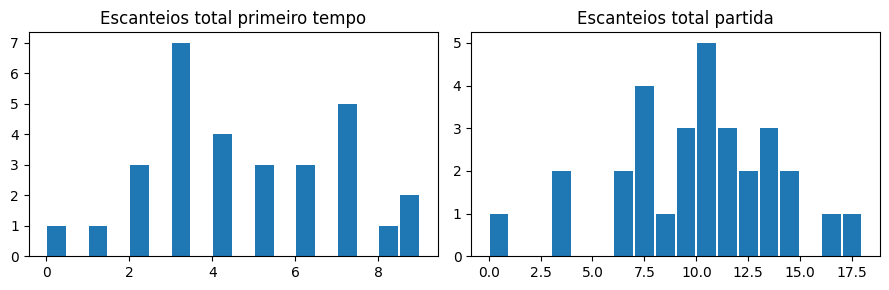

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 7.5 escanteios
1H 85% das partidas + de  1.5 escanteios
1H partidas com menos de 6.5  73 % Fairline: 1.36
1H partidas com menos de 5.5  63 % Fairline: 1.58
1H partidas com menos de 4.5  53 % Fairline: 1.88
1H partidas com mais de 1.5  93 % Fairline: 1.07
1H partidas com mais de 2.5  83 % Fairline: 1.2
1H partidas com mais de 3.5  60 % Fairline: 1.67
JOGO COMPLETO: 
FT 85% das partidas - de  13.5 escanteios
FT 85% das partidas + de  5.5 escanteios
FT partidas com menos de 10.5  60 % Fairline: 1.67
FT partidas com menos de 9.5  43 % Fairline: 2.31
FT partidas com menos de 8.5  33 % Fairline: 3.0
FT partidas com mais de 6.5  83 % Fairline: 1.2
FT partidas com mais de 7.5  70 % Fairline: 1.43
FT partidas com mais de 8.5  67 % Fairline: 1.5
Partidas com saldo de escanteios positivo:  80 %
Partidas com saldo de escanteios negativo:  13 %
Partidas escanteios empatados:  7 %
Média escanteios por partida:  10
desvio padrão:  4


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
1,2,5,7,1,1,2,9,3,6,Home,5,Chelsea
3,4,3,7,1,1,2,9,5,4,Home,5,Southampton
6,1,3,4,0,3,3,7,1,6,Home,1,Leeds
7,3,2,5,1,3,4,9,4,5,Home,1,Crystal Palace
8,1,2,3,2,5,7,10,3,7,Home,-4,Sporting
10,9,8,17,0,1,1,18,9,9,Home,16,Bournemouth
11,2,3,5,1,0,1,6,3,3,Home,4,Everton
14,1,0,1,2,0,2,3,3,0,Home,-1,Man City
15,3,4,7,3,1,4,11,6,5,Home,3,Brentford
18,6,6,12,1,3,4,16,7,9,Home,8,Man Utd


Southampton Jogando fora de casa


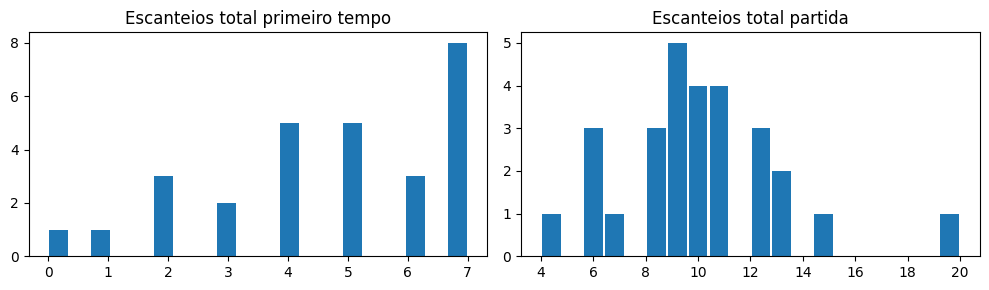

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 7.5 escanteios
1H 85% das partidas + de  1.5 escanteios
1H partidas com menos de 6.5  71 % Fairline: 1.4
1H partidas com menos de 5.5  61 % Fairline: 1.65
1H partidas com menos de 4.5  43 % Fairline: 2.33
1H partidas com mais de 1.5  93 % Fairline: 1.08
1H partidas com mais de 2.5  82 % Fairline: 1.22
1H partidas com mais de 3.5  75 % Fairline: 1.33
JOGO COMPLETO: 
FT 85% das partidas - de  12.5 escanteios
FT 85% das partidas + de  6.5 escanteios
FT partidas com menos de 10.5  61 % Fairline: 1.65
FT partidas com menos de 9.5  46 % Fairline: 2.15
FT partidas com menos de 8.5  29 % Fairline: 3.5
FT partidas com mais de 6.5  86 % Fairline: 1.17
FT partidas com mais de 7.5  82 % Fairline: 1.22
FT partidas com mais de 8.5  71 % Fairline: 1.4
Partidas com saldo de escanteios positivo:  29 %
Partidas com saldo de escanteios negativo:  54 %
Partidas escanteios empatados:  18 %
Média escanteios por partida:  10
desvio padrão:  3


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
0,4,7,11,1,1,2,13,5,8,Away,9,Nottm Forest
1,1,1,2,3,8,11,13,4,9,Away,-9,Newcastle
3,1,1,2,4,3,7,9,5,4,Away,-5,Arsenal
6,1,2,3,1,4,5,8,2,6,Away,-2,West Ham
9,4,4,8,3,4,7,15,7,8,Away,1,Man Utd
12,0,2,2,5,4,9,11,5,6,Away,-7,Leeds
13,0,2,2,1,7,8,10,1,9,Away,-6,Chelsea
15,2,2,4,4,0,4,8,6,2,Away,0,Brentford
16,0,1,1,4,1,5,6,4,2,Away,-4,Newcastle
20,2,2,4,2,4,6,10,4,6,Away,-2,Everton


In [4]:

team_id = 6
team2_id = 20 

home_name, df_home = get_corner_stats(team_id,True)
away_name, df_away = get_corner_stats(team2_id,False)


print(home_name, "Jogando em casa")
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(df_home.total_first_half_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_home.total_match_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()

print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_home.total_first_half_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('1H 85% das partidas + de ', df_home.total_first_half_corners.quantile(0.15, interpolation="lower")-0.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_home.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_home.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_home.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_home.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_home.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_home.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_home.total_match_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('FT 85% das partidas + de ', df_home.total_match_corners.quantile(0.15,interpolation="lower")-0.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_home.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_home.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_home.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_home.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_home.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_home.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_home.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_home.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_home.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_home.total_match_corners).mean()))
print('desvio padrão: ', round((df_home.total_match_corners).std()))
display(df_home)


print(away_name,"Jogando fora de casa")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(df_away.total_first_half_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_away.total_match_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()
print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_away.total_first_half_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('1H 85% das partidas + de ', df_away.total_first_half_corners.quantile(0.15, interpolation="lower")-.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_away.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_away.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_away.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_away.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_away.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_away.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_away.total_match_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('FT 85% das partidas + de ', df_away.total_match_corners.quantile(0.15,interpolation="lower")-.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_away.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_away.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_away.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_away.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_away.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_away.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_away.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_away.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_away.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_away.total_match_corners).mean()))
print('desvio padrão: ', round((df_away.total_match_corners).std()))
display(df_away)
